<h2>Import bibliotek</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

Definicja danych funkcji i funkcji obliczających prawdziwe wartości całkowania dla nich

In [2]:
# 1. function definition
def f1(x):
    return 4 / (1 + x**2)
# 1. function integral correct value (range - [0;1])
def f1_correct():
    return np.pi

# 2. function definition
def f2(x):
    return np.sqrt(x) * np.log(x)
# 2. function integral correct value (range - [0;1])
def f2_correct():
    return -4/9

# 3. function definition
def f3(a, b, x):
    return 1/((x-0.3)**2 + a) + 1/((x-0.9)**2 + b) - 6
# 3. function integral correct value - helper
def f3_int_value(x0, a):
    return 1/np.sqrt(a) * (np.arctan((1-x0)/np.sqrt(a)) + np.arctan(x0/np.sqrt(a)))
# 3. function integral correct value (range - [0;1])
def f3_correct(a, b):
    return f3_int_value(0.3, a) + f3_int_value(0.9, b) - 6

Lista funkcji i ich prawdziwych wartości całkowania

In [15]:
# a, b for the 3. function
a, b = 0.001, 0.004
# define a list of functions
functions = np.array([f1, f2, lambda x: f3(a, b, x)])
# define a list of correct integral values
int_vals = np.array([f1_correct(), f2_correct(), f3_correct(a, b)])

Definicja funkcji obliczającej wartość całki numerycznie

In [4]:
# define method constants
RECT = 0
TRAP = 1
SIMP = 2
GAUSS = 3
TRAP_ADAPT = 4
GAUSS_ADAPT = 5

# integral function for rect, trap and simp
def integrate1(f, range_start, range_end, method, node_count):
    # define formula
    def formula(a, b):
        if method == RECT:
            return (b-a) * f((a+b)/2)
        if method == TRAP:
            return (b-a)/2 * (f(a) + f(b))
        if method == SIMP:
            return (b-a)/6 * (f(a) + 4*f((a+b)/2) + f(b))
        return None

    # calculate integral
    xs = np.linspace(range_start, range_end, node_count)
    return np.sum(formula(xs[:-1], xs[1:]))

# integral function for gauss
def integrate2(f, range_start, range_end, node_count):
    xs, weights = np.polynomial.legendre.leggauss(node_count)
    shifted_xs = (range_start + range_end)/2 + (range_end - range_start)/2 * xs
    return (range_end - range_start)/2 * np.sum(weights * f(shifted_xs))

# integral function for trap_adapt and gauss_adapt
def integrate3(f, range_start, range_end, method, tolerance):
    method_map = {
        TRAP_ADAPT: "trapezoid",
        GAUSS_ADAPT: "gk21"
    }
    res, _, info = sp.integrate.quad_vec(f, range_start, range_end, epsabs=tolerance, quadrature=method_map[method], full_output=True)
    return (res, info.neval)

# define function to calculate integral
# accuracy means node_count for rect, trap, simp and gauss
# accuracy means tolerance for trap_adapt, gauss_adapt
# returns a tuple (result, eval_count)
def integrate(f, range_start, range_end, method, accuracy, offset=1e-20):
    # use offset to avoid limits (esp. f2(x) for x = 0)
    range_start += offset
    range_end -= offset
    # i love python switches
    if method in (RECT, TRAP, SIMP):
        return (integrate1(f, range_start, range_end, method, accuracy), accuracy)
    if method == GAUSS:
        return (integrate2(f, range_start, range_end, accuracy), accuracy)
    if method in (TRAP_ADAPT, GAUSS_ADAPT):
        return integrate3(f, range_start, range_end, method, accuracy)
    return None

Ustalenie liczny węzłów i dopuszczalnych tolerancji

In [5]:
# node count for rect, trap, simp
acc1 = 2**np.arange(1, 26, 1) + 1
# node count for gauss
acc2 = 2**np.arange(1, 14, 1) + 1
# tolerance for trap_adapt, gauss_adapt
acc3 = 10**(-np.arange(0, 15, 1, dtype=np.float64))

Definicja funkcji zwracającej błędy od liczby ewaluacji dla danej funkcji używając wszystkich metod

In [6]:
# get error of eval_count for a integral of a function for all methods
def calc_integrals(f, range_start, range_end, correct_val, acc1, acc2, acc3):
    results = {}
    # define array of methods and array of corresponding accuracies
    method_array = [RECT, TRAP, SIMP, GAUSS, TRAP_ADAPT, GAUSS_ADAPT]
    acc_array = [acc1, acc1, acc1, acc2, acc3, acc3]
    # integrate for all methods and all of given accuracies
    for i in range(len(method_array)):
        method = method_array[i]
        acc = acc_array[i]
        res = np.array([integrate(f, range_start, range_end, method, a) for a in acc])
        results[method] = {"evals": res[:,1], "errors": np.abs((res[:,0] - correct_val) / correct_val)}
    return results

Funkcja rysująca wyniki na wykresie

In [7]:
def plot_results(results):
    # set figsize
    plt.figure(figsize = (12,8))
    # label map
    labels = {
        RECT: "Midpoint rectangular formula",
        TRAP: "Trapezoidal formula",
        SIMP: "Simpson formula",
        GAUSS: "Gauss-Legendre",
        TRAP_ADAPT: "Adaptive trapezoidal",
        GAUSS_ADAPT: "Adaptive Gauss-Kronrod"
    }
    # plot each method
    for method, result in results.items():
        plt.plot(result["evals"], result["errors"], label=labels[method])
    # set title and axes names
    plt.title("Absolute value of relative error for different quadratures dependant on evaluation count")
    plt.xlabel("evaluation count")
    plt.ylabel("abs(relative error)")
    # set both axes to logarithmic scales
    plt.xscale("log")
    plt.yscale("log")
    # show plot with grid and legend
    plt.grid()
    plt.legend()
    plt.show()

<h2>Zadanie 1.</h2>

<h3>$\int_{0}^{1}{\frac{4}{1+x^2}dx} = \pi$</h3>

Obliczenie wyników

In [8]:
results1 = calc_integrals(functions[0], 0, 1, int_vals[0], acc1, acc2, acc3)

Pokazanie wyników na wykresie

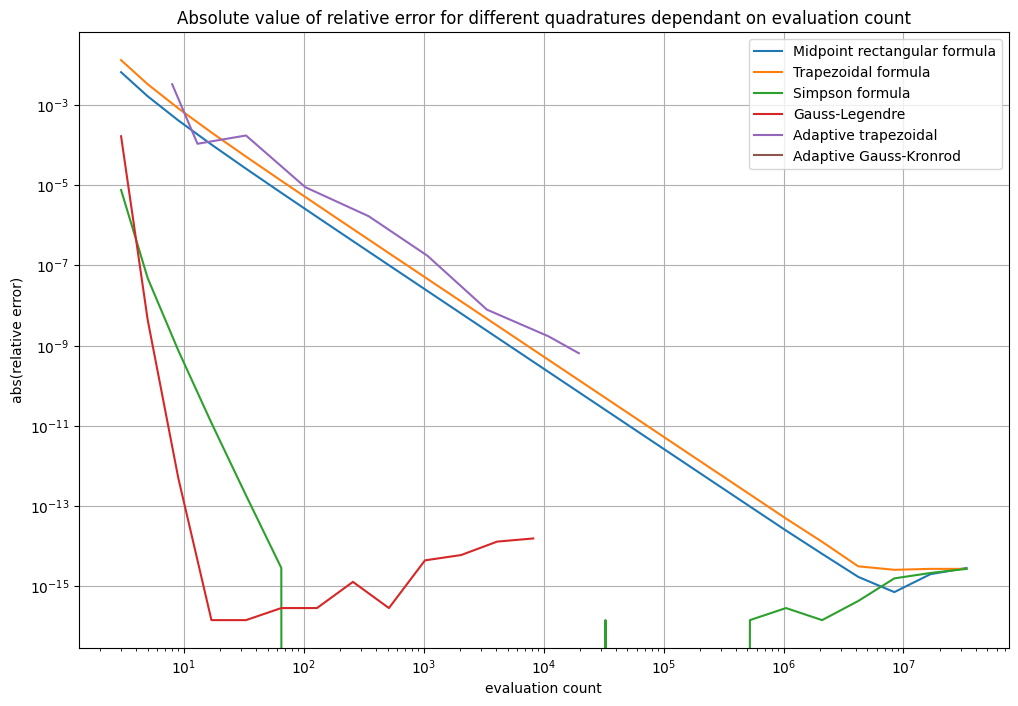

In [9]:
plot_results(results1)

<h2>Zadanie 2.</h2>

<h3>a) $\int_{0}^{1}{\sqrt{x}\log{x}dx} = -\frac{4}{9}$</h3>

Obliczenie wyników

In [10]:
results2a = calc_integrals(functions[1], 0, 1, int_vals[1], acc1, acc2, acc3)

Pokazanie wyników na wykresie

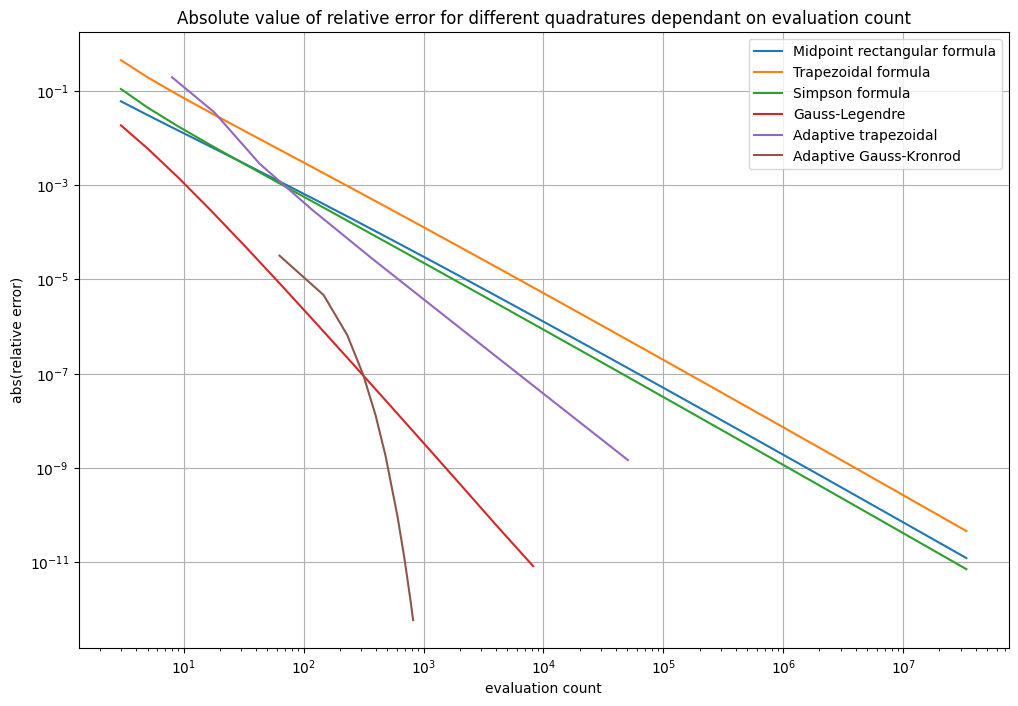

In [11]:
plot_results(results2a)

<h3>b) $\int_{0}^{1}{(\frac{1}{(x - 0.3)^2 + 0.001} + \frac{1}{(x - 0.9)^2 + 0.004} - 6)dx} = 128.244$</h3>

Obliczenie wyników

In [12]:
results2b = calc_integrals(functions[2], 0, 1, int_vals[2], acc1, acc2, acc3)

Pokazanie wyników na wykresie

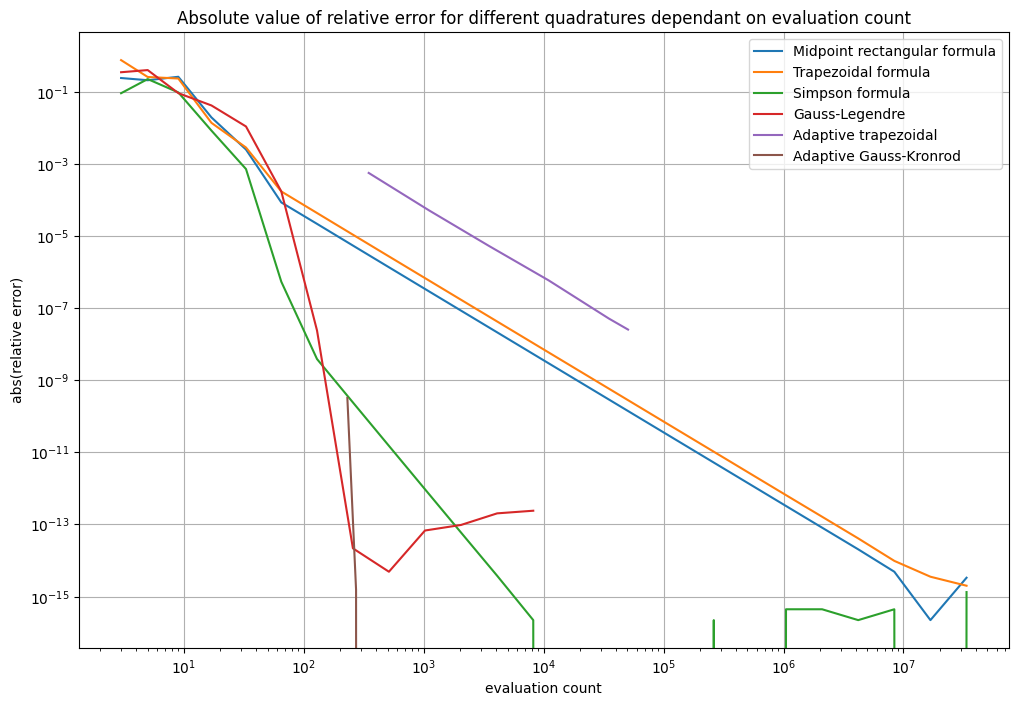

In [13]:
plot_results(results2b)